In [13]:
import numpy as np
import os
import subprocess
import sys
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Using colab?

In [ ]:
colab = True
token = ""
repo_owner = "esemsc-dda24"
repo_name = "PTL-PINNS"

In [15]:
if colab:

    def clone_repo(repo_owner: str, repo_name: str, token: str = None):
        """
        Clone a GitHub repo using a token. Token can be passed or taken from GITHUB_TOKEN env var.
        """
        token = token or os.getenv("GITHUB_TOKEN")
        if not token:
            raise ValueError("GitHub token not provided or found in environment variables.")

        url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"
        target_dir = repo_name

        if not os.path.exists(target_dir):
            try:
                subprocess.run(["git", "clone", url], check=True)
                print(f"Successfully cloned '{repo_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error cloning repo: {e}")
        else:
            print(f"Directory '{target_dir}' already exists; skipping git clone.")

    clone_repo(repo_owner, repo_name, token)
    sys.path
    sys.path.append(f"/content/{repo_name}/")
    !pip install neurodiffeq > /dev/null 2>&1
    %cd /content/{repo_name}
    !ls
    !pip install -e .
    %cd ..

from ptlpinns.models import load, model, training
from ptlpinns.odes import forcing, equations, numerical

Directory 'PTL-PINNS' already exists; skipping git clone.
/content/PTL-PINNS
figures  LICENSE  ptlpinns  pyproject.toml  README.md  torch_failed
Obtaining file:///content/PTL-PINNS
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ptlpinns (pyproject.toml) ... done
  Created wheel for ptlpinns: filename=ptlpinns-1.0.0-py3-none-any.whl size=5244 sha256=752d5d80aef43d0bc454fc19abbf44c71b5a702c7d632684d38d0d352ed4d622
  Stored in directory: /tmp/pip-ephem-wheel-cache-ck1d5pad/wheels/91/e4/15/9f0d5d56fa756580495a263c1ee8809e9a36ee976afe697cad
Successfully built ptlpinns
  Attempting uninstall: ptlpinns
    Found existing installation: ptlpinns 1.0.0
    Uninstalling ptlpinns-1.0.0:
      Successfully uninstalled ptlpinns-1.0.0
/content


## Training equations

In [ ]:
#conf = load.ptl_config("/content/PTL-PINNS/ptlpinns/models/train/config/overdamped.yaml")
conf = load.ptl_config("/content/PTL-PINNS/ptlpinns/models/train/config/overdamped_nonlinear.yaml")

epsilon_list = [0.2, 0.3, 0.4, 0.5, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5]  # to be added to config

# save log
os.makedirs(conf["experiment"], exist_ok = True)
with open(f'{conf["experiment"]}/training_log.json', 'w') as f:
    json.dump(conf, f)

# load values
N = conf["N"]
t_span = (0, conf["t_max"])
t_eval = np.linspace(t_span[0], t_span[1], N)
k, w_list, forcing_freq, forcing_coef = conf["k"], conf["w_list"], conf["forcing_freq"], conf["forcing_coef"]
ic_python_list, zeta_list, mu_list = conf["ic_python_list"], conf["zeta_list"], conf["mu_list"]
ic_list = [load.initial_condition(y1_0=ic[0], y2_0=ic[1]) for ic in ic_python_list]

In [17]:
# define forcing
forcing_list_numpy = [forcing.zeroes_2D(True)] * k
forcing_list_torch = [forcing.zeroes_2D(False)] * k

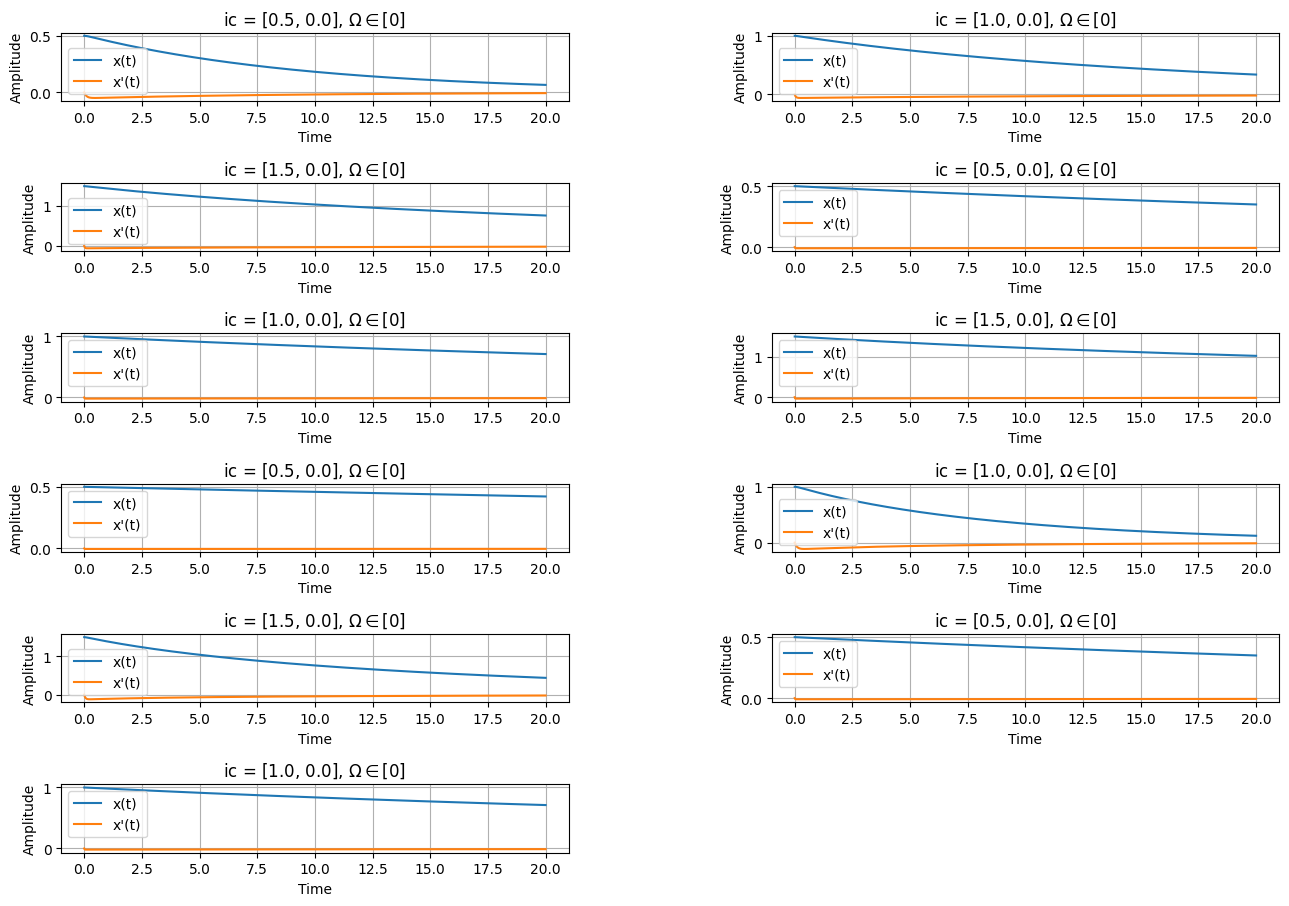

In [18]:
# returns 2D linear equation functions
linear_equation_functions_np = [equations.ode_oscillator(forcing_list_numpy[k],
                                                    w_0=w_list[k],
                                                    epsilon=epsilon_list[k], zeta=zeta_list[k], numpy=True)
                                                    for k in range(k)]

# solves the 2D linear equation functions
title_list = [rf"ic = {ic_python_list[i]}, $\Omega \in {forcing_freq[i]}$"
              for i in range(k)]

linear_solution_list = [numerical.solve_ode_equation(linear_equation_functions_np[index], t_span, t_eval, ic_python_list[index]) for index in range(k)]

# visualize the solutions of the training equations
numerical.plot_multiple_ode_solutions(linear_solution_list,
                                       t_eval, titles=title_list,
                                       suptitle=r"", hspace = 1.2)

## Model Configuration

In [19]:
use_sine, use_fourier, n_frequencies, scale, bias = conf["use_sine"], conf["use_fourier"], conf["n_frequencies"], conf["scale"], conf["bias"]
hidden_layers, num_iter, learning_rate = conf["hidden_layers"], conf["num_iter"], conf["lr"]
step_size, gamma, method = conf["step_size"], conf["gamma"], conf["method"]
ode_weight, ic_weight = conf["w_ode"], conf["w_ic"]


# define model
pinn = model.Multihead_model_fourier(k, bias=bias, HIDDEN_LAYERS=hidden_layers, hidden_act=[nn.Tanh(), nn.Tanh(), nn.Tanh()])

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pinn.to(dev)

Multihead_model_fourier(
  (linear1): Linear(in_features=1, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (final_layers): ModuleList(
    (0-10): 11 x Linear(in_features=128, out_features=1, bias=True)
  )
)

In [20]:
every=100
save_epoch=100
optimizer=torch.optim.Adam(pinn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size/2, gamma=gamma)

In [21]:
step_size/2

400.0

## Train Neural Network on Linear version

In [22]:
equation_functions = []
for i in range(k):
    equation_functions.append(equations.equation_oscillator(w_0=w_list[i], epsilon=epsilon_list[i], zeta=zeta_list[i]))

In [23]:
loss_trace, ode_trace, ic_trace, result_trace = training.train(model=pinn, optimizer=optimizer, num_iter=int(num_iter), equation_functions=equation_functions,
                                                      initial_condition_functions=ic_list, forcing_functions=forcing_list_torch,
                                                      N=N, t_span=t_span, every=every, save_epoch=save_epoch, ode_weight=ode_weight,
                                                      ic_weight=ic_weight, scheduler=scheduler, method=method)

  0%|          | 0/20000 [00:00<?, ?it/s]

100th Iter: total 0.04459189406107726, ode 0.009362411516016977, ic 0.03522948254506029
200th Iter: total 0.008084491162399213, ode 0.005350203897702785, ic 0.0027342872646964277
300th Iter: total 0.0052214553942887655, ode 0.0037927796380495425, ic 0.0014286757562392233
400th Iter: total 0.004240954003211063, ode 0.0028970913745153693, ic 0.0013438626286956944
500th Iter: total 0.0036525676289680745, ode 0.0023448216406881384, ic 0.0013077459882799359
600th Iter: total 0.0032350467434194338, ode 0.0019562671742602965, ic 0.0012787795691591372
700th Iter: total 0.0029188118966998007, ode 0.0016648926425023134, ic 0.001253919254197487
800th Iter: total 0.0026697829608945977, ode 0.0014379118129795533, ic 0.0012318711479150444
900th Iter: total 0.004336955704240843, ode 0.0031186699300957315, ic 0.0012182857741451117
1000th Iter: total 0.0024446713926631106, ode 0.0012518954429723847, ic 0.0011927759496907259
1100th Iter: total 0.002276747338795758, ode 0.0011026402197969118, ic 0.001174

### View results and save

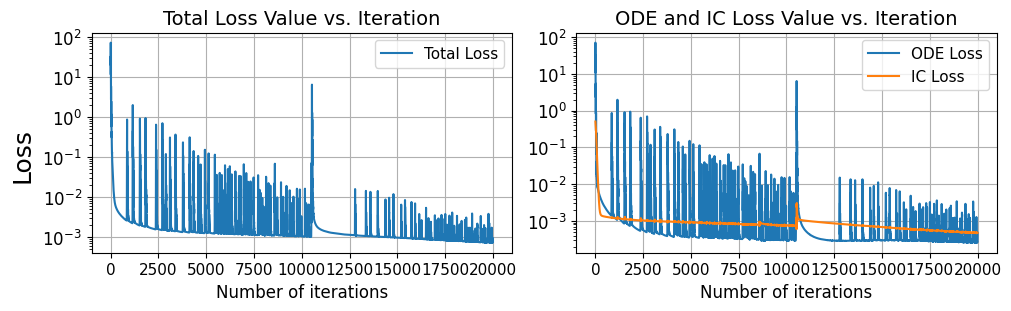

In [24]:
training.plot_loss(loss_trace, ode_trace, ic_trace, path=None)

In [25]:
# compute the NN solutions
pinn.eval()
pinn.to('cpu')
NN_solution, _ = pinn(training.generate_eval_tensor(N=N, t_span=t_span, require_grad=False))
NN_solution = NN_solution.detach().numpy()

name = conf["experiment"]
torch.save(pinn.state_dict(), f"/content/PTL-PINNS/ptlpinns/models/train/{name}/model_{name}.pth")

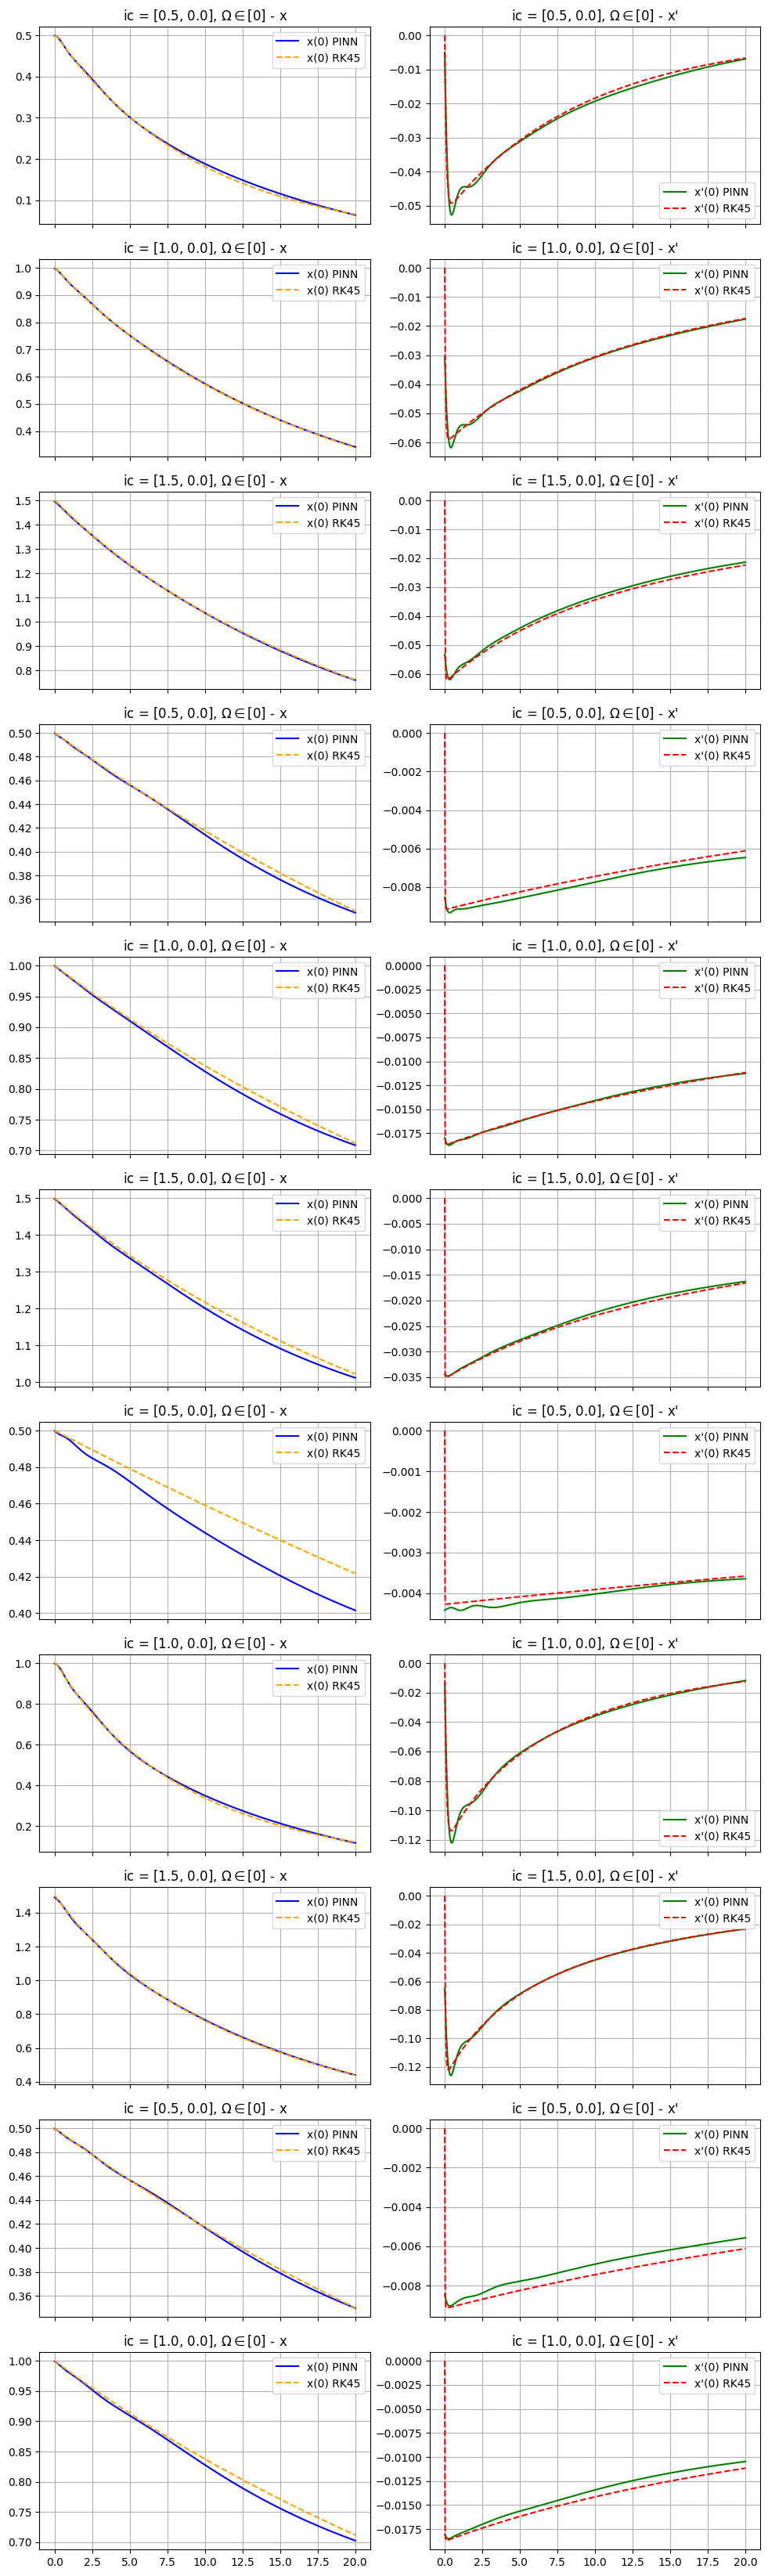

In [26]:
training.compare_training_solutions(NN_solution, linear_solution_list, t_eval, title_list, k)